In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [2]:
df = pd.read_csv('data/preprocessed_data.csv')

In [3]:
df.head()

Winner  title_bout  no_of_rounds  B_current_lose_streak  \
0    Red        True             5                    0.0   
1    Red        True             5                    0.0   
2    Red       False             3                    0.0   
3   Blue       False             3                    0.0   
4   Blue       False             3                    0.0   

   B_current_win_streak  B_draw  B_avg_BODY_att  B_avg_BODY_landed  \
0                   4.0     0.0        9.200000           6.000000   
1                   3.0     0.0       14.600000           9.100000   
2                   3.0     0.0       15.354839          11.322581   
3                   4.0     0.0       17.000000          14.000000   
4                   1.0     0.0       17.000000          14.500000   

   B_avg_CLINCH_att  B_avg_CLINCH_landed       ...         \
0          0.200000             0.000000       ...          
1         11.800000             7.300000       ...          
2          6.741935             4.387097       ...          
3         13.750000            11.000000       ...          
4          2.500000             2.000000       ...          

   B_Stance_Open Stance  B_Stance_Orthodox  B_Stance_Sideways  \
0                     0                  1                  0   
1                     0                  1                  0   
2                     0                  1                  0   
3                     0                  0                  0   
4                     0                  0                  0   

   B_Stance_Southpaw  B_Stance_Switch  R_Stance_Open Stance  \
0                  0                0                     0   
1                  0                0                     0   
2                  0                0                     0   
3                  0                1                     0   
4                  1                0                     0   

   R_Stance_Orthodox  R_Stance_Sideways  R_Stance_Southpaw  R_Stance_Switch  
0                  1                  0                  0                0  
1                  0                  0                  1                0  
2                  1                  0                  0                0  
3                  1                  0                  0                0  
4                  0                  0                  1                0  

[5 rows x 161 columns]

### Normalizing data

In [4]:
df_num = df.select_dtypes(include=[np.float, np.int])

In [5]:
scaler = StandardScaler()

df[list(df_num.columns)] = scaler.fit_transform(df[list(df_num.columns)])

### Splitting into train, test

In [6]:
y = df['Winner']
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

X = df.drop(columns = 'Winner')

X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=0.1, random_state=41)

### Fitting baseline Xgboost

In [7]:
def plot_confusion(cm, classes):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [8]:
def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(f"Best number of estimators = {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    alg.fit(np.array(X_train), np.array(y_train), eval_metric='auc')
    
    #Predict train set:
    dtrain_predictions = alg.predict(np.array(X_train))
    dtrain_predprob = alg.predict_proba(np.array(X_train))[:,1]
        
    #Predict test set:
    dtest_predictions = alg.predict(np.array(X_test))
    dtest_predprob = alg.predict_proba(np.array(X_test))[:,1]
        
    #Print model report:
    print("\nModel Report: ")
    print(f"Accuracy (Test): {accuracy_score(y_test, dtest_predictions):.4f}")
#     print(f"AUC Score (Train): {roc_auc_score(y_train, dtrain_predprob)}")
    print(f"AUC Score (Test): {roc_auc_score(y_test, dtest_predprob):.4f}")
    
    
    return dtest_predictions

Best number of estimators = 100

Model Report: 
Accuracy (Test): 0.6785
AUC Score (Test): 0.7106


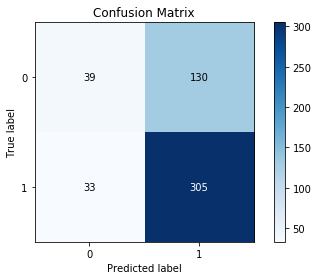

In [9]:
model1 = XGBClassifier(random_state=43, n_jobs=-1)

y1_preds = modelfit(model1, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y1_preds)
classes = unique_labels(y_test, y1_preds)

plot_confusion(cm, classes)

In [10]:
feat_imps = {}
for i, imp in enumerate(model1.feature_importances_):
    feat_imps[X_train.columns[i]] = imp

sorted_imp_feats = (sorted(feat_imps.items(), key = lambda x: x[1], reverse=True))
sorted_imp_feats

[('R_age', 0.051199999),
 ('B_age', 0.033599999),
 ('no_of_rounds', 0.032000002),
 ('R_avg_opp_SIG_STR_pct', 0.025599999),
 ('B_avg_TD_att', 0.024),
 ('R_Weight_lbs', 0.024),
 ('B_avg_opp_TOTAL_STR_landed', 0.022399999),
 ('R_avg_opp_HEAD_landed', 0.022399999),
 ('R_avg_TOTAL_STR_landed', 0.019200001),
 ('R_total_time_fought(seconds)', 0.019200001),
 ('B_avg_DISTANCE_landed', 0.0176),
 ('B_Reach_cms', 0.0176),
 ('R_avg_HEAD_landed', 0.0176),
 ('R_avg_TOTAL_STR_att', 0.0176),
 ('R_avg_TD_pct', 0.016000001),
 ('R_avg_opp_DISTANCE_landed', 0.016000001),
 ('R_avg_opp_PASS', 0.016000001),
 ('B_avg_BODY_att', 0.0144),
 ('B_avg_SIG_STR_att', 0.0144),
 ('B_avg_opp_CLINCH_att', 0.0144),
 ('B_avg_opp_KD', 0.0144),
 ('B_avg_opp_SUB_ATT', 0.0128),
 ('R_avg_LEG_landed', 0.0128),
 ('R_avg_TD_att', 0.0128),
 ('R_losses', 0.0128),
 ('R_avg_opp_DISTANCE_att', 0.0128),
 ('R_avg_opp_REV', 0.0128),
 ('R_avg_opp_SIG_STR_landed', 0.0128),
 ('B_avg_opp_BODY_att', 0.0112),
 ('B_avg_opp_DISTANCE_att', 0.0112),

### Since dataset is imbalanced let's try setting scale_pos_weight to see if we get an improvement

Best number of estimators = 100

Model Report: 
Accuracy (Test): 0.6884
AUC Score (Test): 0.7136


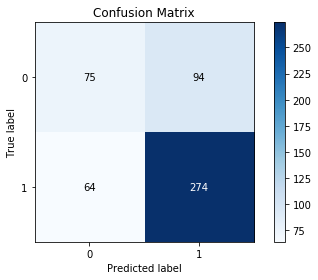

In [11]:
model2 = XGBClassifier(random_state=43, n_jobs=-1, scale_pos_weight=0.7)

y2_preds = modelfit(model2, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y2_preds)
classes = unique_labels(y_test, y2_preds)

plot_confusion(cm, classes)

### Hyperparameter tuning 

Best number of estimators = 71

Model Report: 
Accuracy (Test): 0.6785
AUC Score (Test): 0.7174


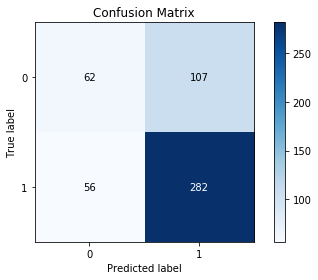

In [12]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.75,
)

y3_preds = modelfit(model3, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y3_preds)
classes = unique_labels(y_test, y3_preds)

plot_confusion(cm, classes)

### Oversampling

In [13]:
from imblearn.over_sampling import ADASYN

In [14]:
over_sampler = ADASYN()
X_resampled, y_resampled = over_sampler.fit_sample(X_train, y_train)

In [15]:
pd.Series(y_resampled).value_counts()

0    3303
1    3132
dtype: int64

Best number of estimators = 100

Model Report: 
Accuracy (Test): 0.6548
AUC Score (Test): 0.6858


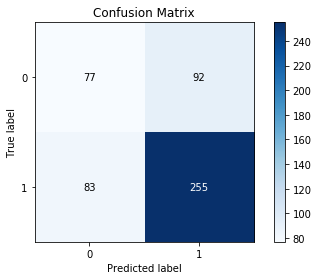

In [16]:
model4 = XGBClassifier(n_jobs=-1, random_state=43)

y4_preds = modelfit(model4, X_resampled, y_resampled, X_test, y_test)

cm = confusion_matrix(y_test, y4_preds)
classes = unique_labels(y_test, y4_preds)

plot_confusion(cm, classes)

### Hyperparameter tuning for the oversampled data

Best number of estimators = 244

Model Report: 
Accuracy (Test): 0.6706
AUC Score (Test): 0.7000


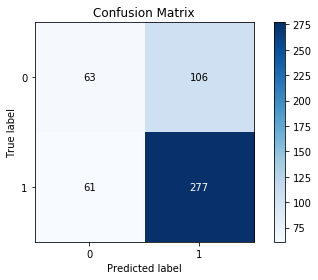

In [17]:
model5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=244,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
)

y5_preds = modelfit(model5, X_resampled, y_resampled, X_test, y_test)

cm = confusion_matrix(y_test, y5_preds)
classes = unique_labels(y_test, y5_preds)

plot_confusion(cm, classes)


Model Report: 
Accuracy (Test): 0.7002
AUC Score (Test): 0.7220


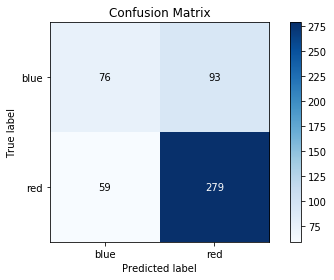

In [18]:
model6 = XGBClassifier(learning_rate =0.1, n_estimators=244, max_depth=4,
                     min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', reg_alpha= 0, scale_pos_weight=1)

y6_preds = modelfit(model6, X_resampled, y_resampled, X_test, y_test, useTrainCV=False)

cm = confusion_matrix(y_test, y6_preds)
classes = ['blue', 'red']

plot_confusion(cm, classes)

In [19]:
X_os, y_os = X_resampled, y_resampled = over_sampler.fit_sample(X, label_encoded_y)

In [20]:
print(classification_report(y_test, y1_preds))

             precision    recall  f1-score   support

          0       0.54      0.23      0.32       169
          1       0.70      0.90      0.79       338

avg / total       0.65      0.68      0.63       507



In [21]:
print(classification_report(y_test, y2_preds))

             precision    recall  f1-score   support

          0       0.54      0.44      0.49       169
          1       0.74      0.81      0.78       338

avg / total       0.68      0.69      0.68       507



In [22]:
print(classification_report(y_test, y3_preds))

             precision    recall  f1-score   support

          0       0.53      0.37      0.43       169
          1       0.72      0.83      0.78       338

avg / total       0.66      0.68      0.66       507



In [23]:
print(classification_report(y_test, y4_preds))

             precision    recall  f1-score   support

          0       0.48      0.46      0.47       169
          1       0.73      0.75      0.74       338

avg / total       0.65      0.65      0.65       507



In [24]:
print(classification_report(y_test, y5_preds))

             precision    recall  f1-score   support

          0       0.51      0.37      0.43       169
          1       0.72      0.82      0.77       338

avg / total       0.65      0.67      0.66       507



In [25]:
print(classification_report(y_test, y5_preds))

             precision    recall  f1-score   support

          0       0.51      0.37      0.43       169
          1       0.72      0.82      0.77       338

avg / total       0.65      0.67      0.66       507



In [26]:
print(classification_report(y_test, y6_preds))

             precision    recall  f1-score   support

          0       0.56      0.45      0.50       169
          1       0.75      0.83      0.79       338

avg / total       0.69      0.70      0.69       507



In [29]:
model = model6

model.fit(np.array(X_os), np.array(y_os))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=244, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [30]:
with open('data/model-os.sav', 'wb') as mdl:
    pickle.dump(model, mdl)